In [1]:
import torch 
import soundfile as sf
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import pandas as pd
from os import (listdir,remove)
import random
import cv2

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
np.set_printoptions(precision=10)
%precision 25

'%.25f'

In [3]:
def get_audio_data(ap, max_length=5):
    y, sr = sf.read(ap)
    y, sr = trim_audio_data(y, sr, max_length=5)
    return y, sr

In [4]:
def trim_audio_data(y, sr, max_length=5):
    length = y.shape[0]
    effective_length = sr * max_length

    if length < effective_length:
        new_y = np.zeros(effective_length, dtype=y.dtype)
        start = np.random.randint(effective_length - length)
        new_y[start:start + length] = y
        y = new_y.astype(np.float32)
    elif length > effective_length:
        start = np.random.randint(length - effective_length)
        y = y[start:start + effective_length].astype(np.float32)
    else:
        y = y.astype(np.float32)

    return y, sr

In [5]:
def mix_awg_noise(y, sr, SNR_db=10):
    # SNR in db  SNR = 10*log10 Pdata/PNoise
    # https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
    # We can experiment with SNR_db
    audio_watts = y**2
    sig_avg_watts = np.mean(audio_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    noise_avg_db = sig_avg_db - SNR_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    noise_volts = np.random.normal(
        0, np.sqrt(noise_avg_watts), len(audio_watts))
    y_volts = y + noise_volts
    return y_volts, sr

In [31]:
noise_dir = Path("../../__noise__/random")
def mix_background_noise(y, sr, coeff):
    """Adds noise to provided audio clip

    Args:
        y: audio file wihtout noise
        coeff: coeff is the proportion of noise to be added
    """
    noise_file_path = random.choice(listdir(noise_dir))
    noise_file_path = noise_dir / noise_file_path
    # if you want fix noise then manually select one
    #noise_file_path= Path("cornell_birdcall_identification/__noise__/random/Nature_2_0.wav")
    print(noise_file_path)
    n_y, n_sr = get_audio_data(noise_file_path)
    ipd.Audio(n_y, rate=sr)
    noise_energy = np.sqrt(n_y.dot(n_y))
    audio_energy = np.sqrt(y.dot(y))
    val=coeff*(audio_energy/noise_energy)
    y = y +   (coeff * n_y * (audio_energy / noise_energy))
    return y, sr

In [32]:
def time_shift(y, sr):
    start_ = int(np.random.uniform(-80000, 80000))
    if start_ >= 0:
        y_new = np.r_[y[start_:], np.random.uniform(-0.001, 0.001, start_)]
    else:
        y_new = np.r_[np.random.uniform(-0.001, 0.001, -start_), y[:start_]]

    return y_new, sr

In [33]:
def speed_tune(y, sr, speed_rate=None):
    if not speed_rate:
        speed_rate = np.random.uniform(0.6, 1.3)

    y_new = cv2.resize(y, (1, int(len(y) * speed_rate))).squeeze()
    if len(y_new) < len(y):
        pad_len = len(y) - len(y_new)
        y_new = np.r_[np.random.uniform(-0.001, 0.001, int(pad_len/2)),
                      y_new,
                      np.random.uniform(-0.001, 0.001, int(np.ceil(pad_len/2)))]
    else:
        cut_len = len(y_new) - len(y)
        y_new = y_new[int(cut_len/2):int(cut_len/2)+len(y)]

    return y_new, sr

In [34]:
def stretch_audio(y, sr, rate=None):
    if not rate:
        rate = np.random.uniform(0.5, 1.5)

    input_length = len(y)

    y = librosa.effects.time_stretch(y, rate)

    if len(y) > input_length:
        y = y[:input_length]
    else:
        y = np.pad(y, (0, max(0, input_length - len(y))), "constant")

    return y, sr


In [35]:
def pitch_shift(y, sr, n_steps=None):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps), sr

In [36]:
def polarity_inversion(y, sr):
    return -y, sr

In [37]:
def amp_gain(y, sr, min_gain_in_db=-12, max_gain_in_db=12):
    assert min_gain_in_db <= max_gain_in_db
    min_gain_in_db = min_gain_in_db
    max_gain_in_db = max_gain_in_db

    amplitude_ratio = 10**(random.uniform(min_gain_in_db, max_gain_in_db)/20)
    return y * amplitude_ratio, sr

In [38]:
def add_gaussian_noise(y, sr):
    noise = np.random.randn(len(y))
    y_new = y + 0.005*noise
    return y_new, sr

In [39]:

audio_test=Path("../../__data__/bird_song/audio/rufgro/XC260212.wav")

In [56]:
y,sr=sf.read(audio_test)
y_trim,sr=trim_audio_data(y, sr, max_length=5)
y_background,sr=mix_background_noise(y_trim, sr, 0.5)
y_shift , sr = time_shift(y_trim,sr)
y_speed , sr = speed_tune(y_trim,sr)
y_awgn_snr , sr = mix_awg_noise(y_trim,sr,SNR_db=20)
y_gn ,  sr = add_gaussian_noise(y_trim,sr)
y_amp , sr = amp_gain(y_trim,sr)
y_pitch_shift , sr = pitch_shift(y_trim,sr,4)
y_stretch , sr = stretch_audio(y_trim,sr)
y_polarity_inversion , sr = polarity_inversion(y_trim, sr)

../../__noise__/random/Nature_2_2.wav


In [57]:
aug = [y_background,y_shift,y_speed,y_awgn_snr,y_gn,y_amp,y_pitch_shift,y_stretch]

In [58]:
count = 0
for n,x in enumerate(aug):
    for i in range(len(y_trim)):
        if y_trim[i]!=x[i]:
            count+=1
    if count >= 0.9*(y_trim.shape[0]):
        print(f"The augmentation is working")


The augmentation is working
The augmentation is working
The augmentation is working
The augmentation is working
The augmentation is working
The augmentation is working
The augmentation is working
The augmentation is working


In [59]:
ipd.Audio(y_trim,rate=sr)

In [60]:
ipd.Audio(y_shift, rate=sr) 

In [61]:
ipd.Audio(y_speed, rate=sr) 

In [62]:
ipd.Audio(y_awg, rate=sr)

In [63]:
ipd.Audio(y_gn, rate=sr)

In [64]:
ipd.Audio(y_amp, rate=sr)

In [65]:
ipd.Audio(y_pitch_shift,rate=sr) 

In [66]:
ipd.Audio(y_stretch,rate=sr) 

In [89]:
ipd.Audio(y_background,rate=sr)

In [68]:
ipd.Audio(y_polarity_inversion,rate=sr)

In [69]:
data_path = Path("../../__data__/bird_song")
csv_path = data_path / "train.csv"
df =pd.read_csv(csv_path)

In [70]:
tot=0
audio_path =data_path / "audio"
for folders in listdir(audio_path):
    tot+=len([files for files in listdir( audio_path / folders)])
print(f' The total files in {audio_path} are {tot}')
print(f' The total files in csv are {len(df)}')

 The total files in ../../__data__/bird_song/audio are 21375
 The total files in csv are 21375


In [71]:
samples = np.random.randint(len(df),size=20)
samples

array([19989, 20927,  3420, 20599, 12005, 15497,  3739,   643,  9975,
        6646, 14071, 17656,  4278, 19182, 12719, 19680,  9765, 15466,
         587,  7769])

In [72]:
sample_path=[audio_path / df.iloc[idx]["ebird_code"] / df.iloc[idx]["filename"] for idx in samples]
sample_bird_name = [df.iloc[idx]["ebird_code"] for idx in samples]

In [73]:
audios = []
# create a folder or set a location to save the randomly sampled augmentations
!mkdir test_noise_augmentations
clean_samples = Path('test_noise_augmentations')
for  i,paths in enumerate(sample_path):
    y, sr = sf.read(paths)
    y_trim,sr=trim_audio_data(y, sr, max_length=5)
    y_background,sr=mix_background_noise(y_trim, sr, 0.5)
    y_shift , sr = time_shift(y_trim,sr)
    y_speed , sr = speed_tune(y_trim,sr)
    y_awgn_snr , sr = mix_awg_noise(y_trim,sr,SNR_db=20)
    y_gn ,  sr = add_gaussian_noise(y_trim,sr)
    y_amp_gain , sr = amp_gain(y_trim,sr)
    y_pitch_shift , sr = pitch_shift(y_trim,sr,4)
    y_stretch , sr = stretch_audio(y_trim,sr)

    sf.write(clean_samples / str(sample_bird_name[i] + "_shift" ".wav"), y_shift, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + "_speed" ".wav"), y_speed, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + "_gn" ".wav"), y_gn, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + "_amp_gain" ".wav"), y_amp_gain, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + "_pitch_shift" ".wav"), y_pitch_shift, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + "_stretch" ".wav"), y_stretch, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + "_background" ".wav"), y_background, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + "_awgn_snr" ".wav"), y_awgn_snr, sr)
    sf.write(clean_samples / str(sample_bird_name[i] + ".wav"), y_trim, sr) 
    

../../__noise__/random/White_noise_8_2.wav
../../__noise__/random/White_noise_2_7.wav
../../__noise__/random/Nature_5_15.wav
../../__noise__/random/Nature_5_5.wav
../../__noise__/random/White_noise_0_8.wav
../../__noise__/random/White_noise_5_0.wav
../../__noise__/random/White_noise_3_2.wav
../../__noise__/random/Nature_8_18.wav
../../__noise__/random/Nature_6_18.wav
../../__noise__/random/Nature_1_16.wav
../../__noise__/random/White_noise_2_1.wav
../../__noise__/random/White_noise_3_10.wav
../../__noise__/random/Nature_8_2.wav
../../__noise__/random/White_noise_0_4.wav
../../__noise__/random/Nature_5_24.wav
../../__noise__/random/Nature_6_26.wav
../../__noise__/random/Nature_5_23.wav
../../__noise__/random/Nature_6_20.wav
../../__noise__/random/White_noise_5_5.wav
../../__noise__/random/Nature_6_11.wav


../../__data__/bird_song/audio/whtspa/XC217366.wav
../../__noise__/random/Nature_1_7.wav
(160000,)


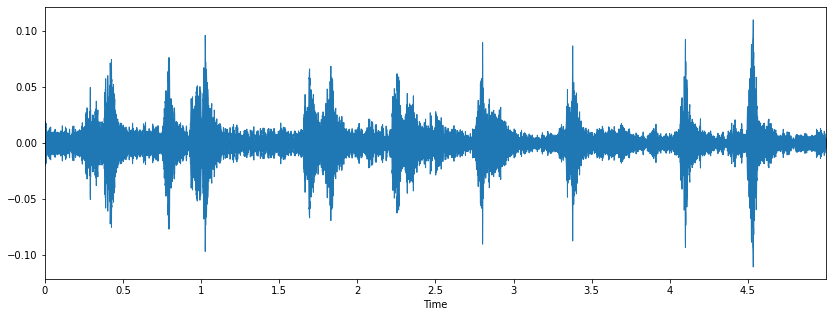

In [74]:
for i,paths in enumerate(sample_path):
    print(sample_path[i])
    y, sr = sf.read(paths)
    y_trim,sr=trim_audio_data(y, sr, max_length=5)
    y_background,sr=mix_background_noise(y_trim, sr, 0.5)
    y_shift , sr = time_shift(y_trim,sr)
    y_speed , sr = speed_tune(y_trim,sr)
    y_awgn_snr , sr = mix_awg_noise(y_trim,sr,SNR_db=20)
    y_gn ,  sr = add_gaussian_noise(y_trim,sr)
    y_amp_gain , sr = amp_gain(y_trim,sr)
    y_pitch_shift , sr = pitch_shift(y_trim,sr,4)
    y_stretch , sr = stretch_audio(y_trim,sr)
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(y_trim, sr=sr)
    print(y_trim.shape)
    break


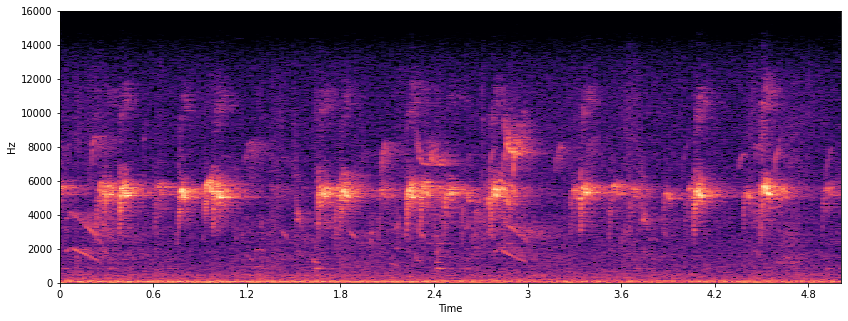

In [75]:
x=y_trim
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

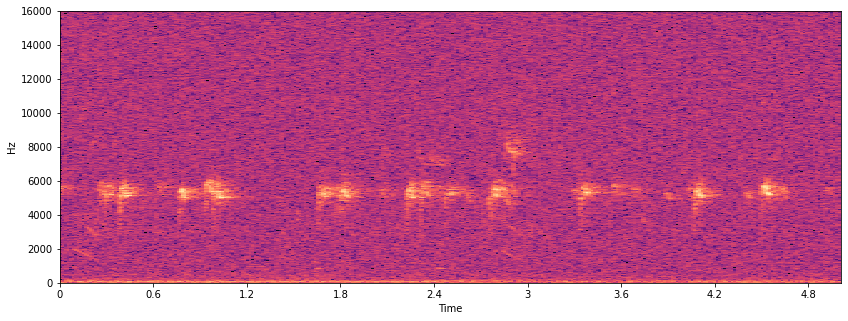

In [76]:
x=y_gn
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

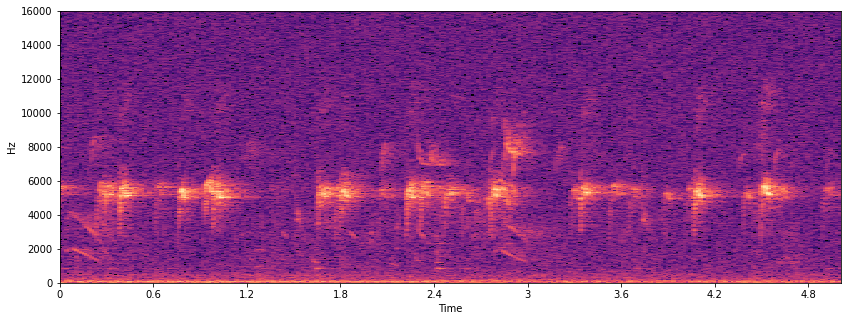

In [77]:
x=y_awgn_snr
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

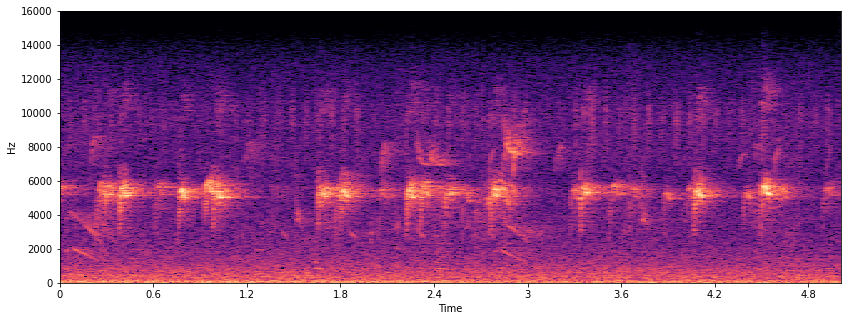

In [78]:
x=y_background
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

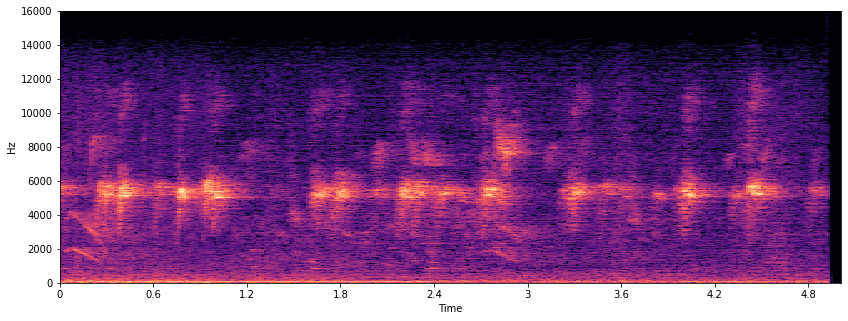

In [79]:
x=y_stretch
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

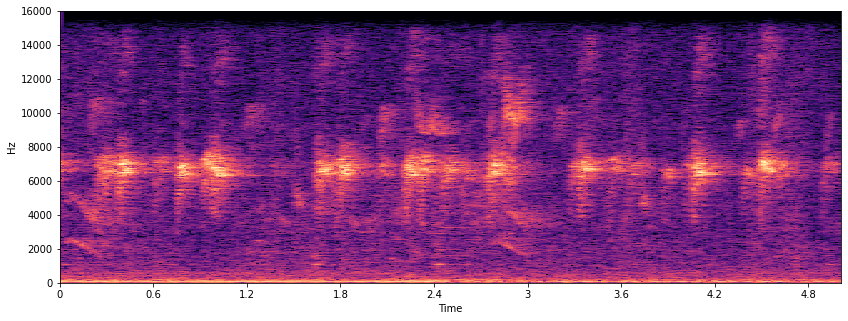

In [80]:
x=y_pitch_shift
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

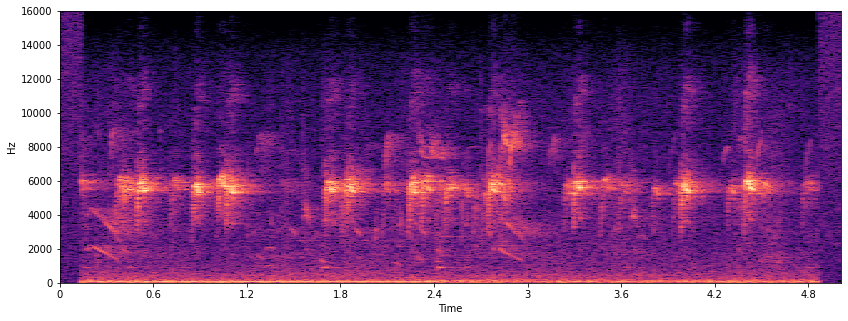

In [81]:
x=y_speed
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

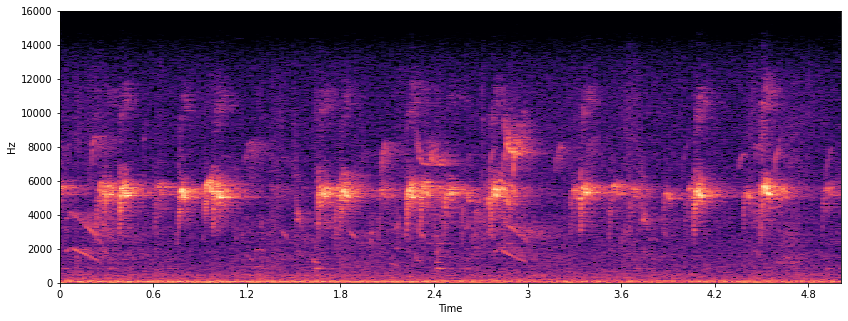

In [82]:
x=y_amp_gain
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

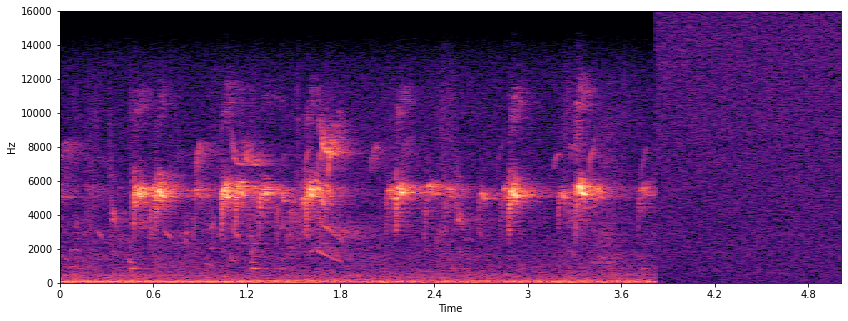

In [83]:
x=y_shift
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')